# Week 9: Corner Detection


### Date: 30th November, 2023

Last week you learned about corner detection algorithms and how these can be used to find
interesting features on an image that can be used in applications such as stereo matching,
3D reconstruction, tracking, localization and recognition.
Your task today is to code two corner detection algorithms, the Moravec and the Harris
corner detector.

In [26]:
import numpy as np
import copy
import cv2
from matplotlib import pyplot as plt
import random
from PIL import Image
#to visualize the plots within the notebook
%matplotlib inline
# for making plots looking nicer
plt.style.use('fivethirtyeight')

## Task 1: Moravec corner detector

The Moravec corner detector uses a patch centred on each pixel as its own matching
template. The patch is shifted so that it is centred on each of the 8 neighbours of the pixel
and the sum of squared differences (SSD) is calculated between the original patch and the
shifted patch:

$$
    E = \sum_{\Delta \mathbf{x}} w(\Delta \mathbf{x})\big(I(\mathbf{x} + \Delta \mathbf{x}) - I(\mathbf{x}^{\prime} + \Delta \mathbf{x}\big))^2
$$


$w$ is a weighting function with the same dimension as the patch, you can use a Gaussian or constant weights. The corner metric (cornerness) is then taken to be the minimum of the SSD values calculated for each of the eight shifts of the window.
A pixel is marked as a corner if its cornerness is above a user-specified threshold.


Your task is to write your implementation of the Moravec corner detector.
It will take as input a grayscale image, the window size, the threshold and optionally a Gaussian function for $w$. It will give as output a corner map as a list of pixel coordinates where a corner is detected.


In [27]:
def draw_corners(image, corners_map, color=(255, 0, 0)):
    """Draw a point for each possible corner.
    color image: [H, W, 3]
    corners_map: list of pixel coordinates (xy indexing) 
    """
    
    color_img = cv2.cvtColor(image[:,:,0], cv2.COLOR_GRAY2BGR)
    for corner in corners_map:
        cv2.circle(color_img, corner, 1, color, -1)
    return color_img

"""
Utility functions here, you can use code from the last week. FFT implementation is reccomended as it is faster.
"""
def get_mean_filter_kernel(h, w):
    kernel = np.ones((h, w)) / (h*w) # np.ones() is a function that creates a matrix of ones with the given shape (h, w)
    return kernel

def get_gaussian_kernel(h, w, sigma):
    x,y = np.meshgrid(np.linspace(-(w//2), (w//2), w), np.linspace(-(h//2), (h//2), h)) 
    kernel = np.exp(-(x**2 + y**2)/(2*sigma**2)) / (2*np.pi*sigma**2)
    kernel = kernel / kernel.sum()
    return kernel

"""
Implement your moravec detector here.
"""
def moravec(image, window_size=3, threshold=100., weights=None):
    """Moravec's corner detection for each pixel of the image.
    image: grayscale image: [H, W]
    """
    assert window_size % 2 == 1, "window size should be an odd number"
    
    if weights is None:
        weights = get_mean_filter_kernel(window_size, window_size)
    else:
        weights = weights 
    
    pad = window_size // 2
    padded_image = np.pad(image, pad, mode='reflect')  
    corner_response = np.full_like(image, np.inf)
    
    shifts = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]
    
    for dx, dy in shifts:
        # shift the image with the padded area 
        shifted_image = np.roll(np.roll(padded_image, dy, axis=0), dx, axis=1)
        
        ssd = (padded_image - shifted_image)**2
        weighted_ssd = cv2.filter2D(ssd, -1, weights)[pad:-pad, pad:-pad] 
        
        corner_response = np.minimum(weighted_ssd, corner_response)
    
    corners = np.argwhere(corner_response > threshold)
    corners = [(c, r) for r,c in corners] # (x, y) indexing
    return corners


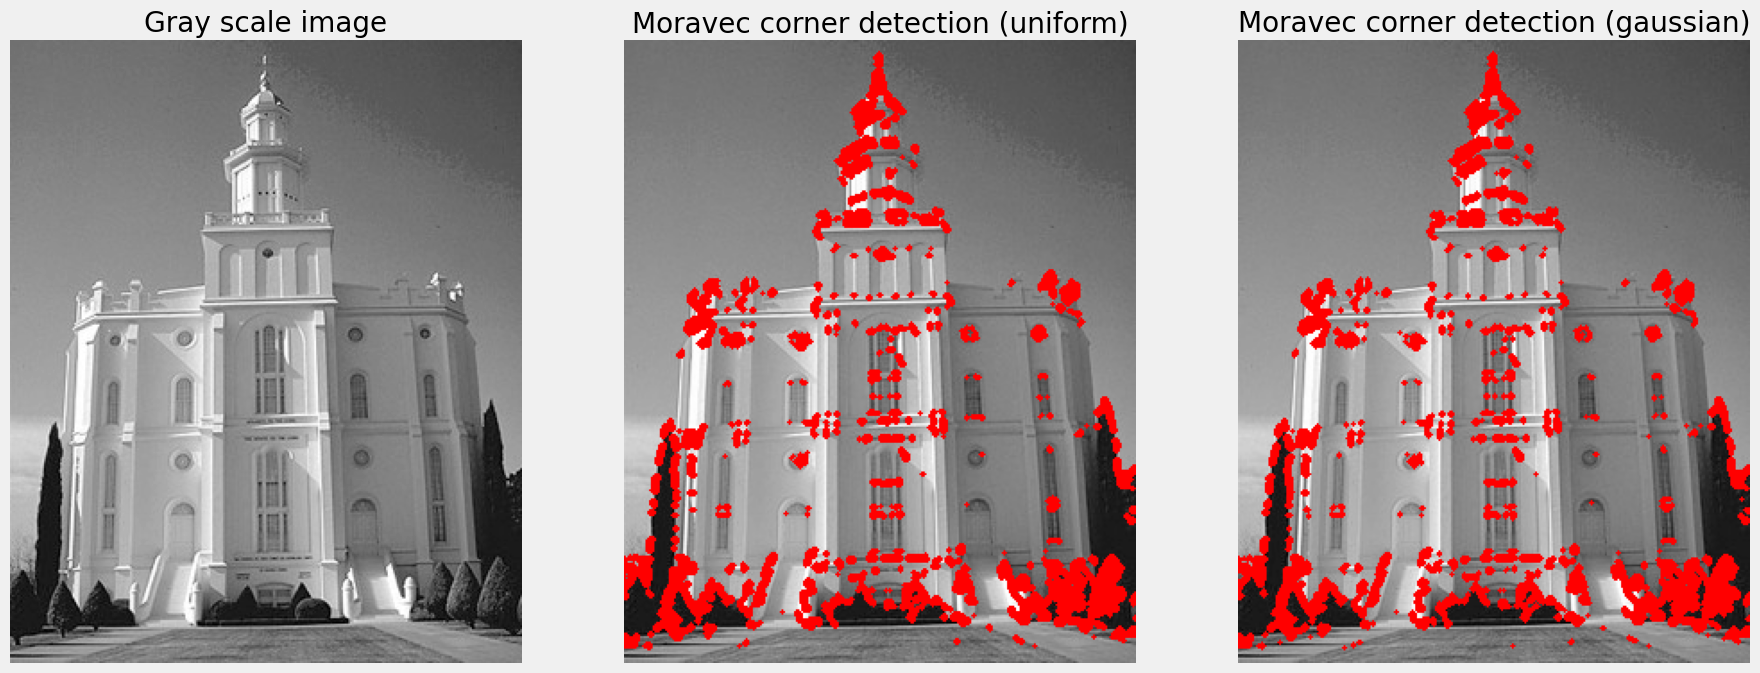

In [28]:
img = cv2.imread('../images/building.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

moravec_corners = moravec(gray_img, threshold=200., weights=None)
img_with_corner = draw_corners(img, moravec_corners)

moravec_corners2 = moravec(gray_img, threshold=200., weights=get_gaussian_kernel(3, 3, 1.0))
img_with_corner2 = draw_corners(img, moravec_corners2)

# Show Original and detected corners on image
fig, axis = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
axis[0].imshow(gray_img, 'gray')
axis[0].grid(False)
axis[0].set_title('Gray scale image')
axis[0].set_axis_off()

axis[1].imshow(img_with_corner, 'gray')
axis[1].grid(False)
axis[1].set_title('Moravec corner detection (uniform)')
axis[1].set_axis_off()

axis[2].imshow(img_with_corner2, 'gray')
axis[2].grid(False)
axis[2].set_title('Moravec corner detection (gaussian)')
axis[2].set_axis_off()

plt.show()

## Task 2: Harris corner detector

The Harris corner detector builds upon the concepts of the Moravec corner detector, but
overcomes its limitations by generalising the measure of cornerness.
The basic limitation of the Moravec detector is that it only calculates cornerness for the 8 main directions
corresponding to the neighbours of a pixel, which means it will not detect a corner in any other direction.
The Harris detector uses the image structure tensor to overcome this. The image structure tensor is:

$$
    S = 
    \begin{pmatrix}
     \sum I^2_x   & \sum I_x I_y\\
     \sum I_x I_y & \sum I^2_x
    \end{pmatrix}
$$

where $I_x$ is the partial derivative of the image in the x direction and $I_y$ is the partial derivative of the image in the y direction.
The structure tensor summarizes the main directions of the gradient of the image for every pixel and therefore its two eigenvalues can be used to determine whether there is a corner at a pixel (if both eigenvalues are large).
The cornerness response metric is then defined as follows:

$$
    C = \text{det}(S) - k \text{tr}(S)^2 \\
$$

where $k$ is a an empirically determined hyper-parameter, usually in the range of $[0.04, 0.06]$

### Non-maximum Suppression (NMS)

In most cases, naivly thresholding the response map will lead to a lot of false-positives, i.e. blobs around real corners. One way to mitigate this to use Non-maximum Suppression (NMS). There is a number of ways of doing it, but the principle is to only keep the pixel with maxium response for aby local regions. You can try by simply setting pixels that have an 8 neighbour with higher cornerness to zero.

In [29]:
"""
Utility functions here, you can use code from the last week. FFT implementation is reccomended as it is faster.
"""
def apply_filter(src_img, kernel):
    h, w = src_img.shape
    kh, kw = kernel.shape
    
    pad_h = (h - kh) // 2
    pad_w = (w - kw) // 2
    kernel_padded = np.pad(kernel, ((pad_h, h - kh - pad_h), (pad_w, w - kw - pad_w)), mode='constant')
    
    fft_img = np.fft.fft2(src_img)
    fft_kernel = np.fft.fft2(kernel_padded)
    
    fft_img_kernel = fft_img * fft_kernel
    filtered_img = np.fft.ifft2(fft_img_kernel).real
    filtered_img = np.fft.ifftshift(filtered_img)  # move the zero frequency component to the center
    
    return filtered_img

def apply_gaussian_filter(src_img, k=5, sigma=1.0):
    kernel = get_gaussian_kernel(k, k, sigma)
    return apply_filter(src_img, kernel)
    
def gradientX(image, mode="fft"):
    kernel = np.array([[-1., 0., 1.],
                       [-2., 0., 2.],
                       [-1., 0., 1.]]) / 9.
    filtered_image = apply_filter(image, kernel)
    return filtered_image

def gradientY(image, mode="fft"):
    kernel = np.array([[-1., -2., -1.],
                       [0., 0., 0.],
                       [1., 2., 1.]]) / 9.
    filtered_image = apply_filter(image, kernel)
    return filtered_image

def harris_response(image, k):
    Ix = gradientX(image)
    Iy = gradientY(image)
    
    Ix2 = Ix**2
    Iy2 = Iy**2
    Ixy = Ix * Iy
    
    Ix2 = apply_gaussian_filter(Ix2)
    Iy2 = apply_gaussian_filter(Iy2)
    Ixy = apply_gaussian_filter(Ixy)
    
    det = Ix2 * Iy2 - Ixy**2
    trace = Ix2 + Iy2
    
    response = det - k * trace**2 # response is in format [H, W]
    return response


def nms(response, threshold, window_size=3):
    """Non-maximum suppression.
    response: corner response map [H, W]
    threshold: threshold for corner response
    window_size: window size for non-maximum suppression
    """
    h,w = response.shape
    nms_response = []
    
    for (r,c) in np.argwhere(response > threshold): # np.argwhere returen the indices of the elements (rows, cols) that are non-zero
        # check if the corner is in the border of the image
        if r < window_size//2 or r >= h-window_size//2 or c < window_size//2 or c >= w-window_size//2:
            continue
        else:
            window = response[r-window_size//2:r+window_size//2+1, c-window_size//2:c+window_size//2+1]
            if response[r,c] == np.max(window):
                nms_response.append([c,r])
    return nms_response


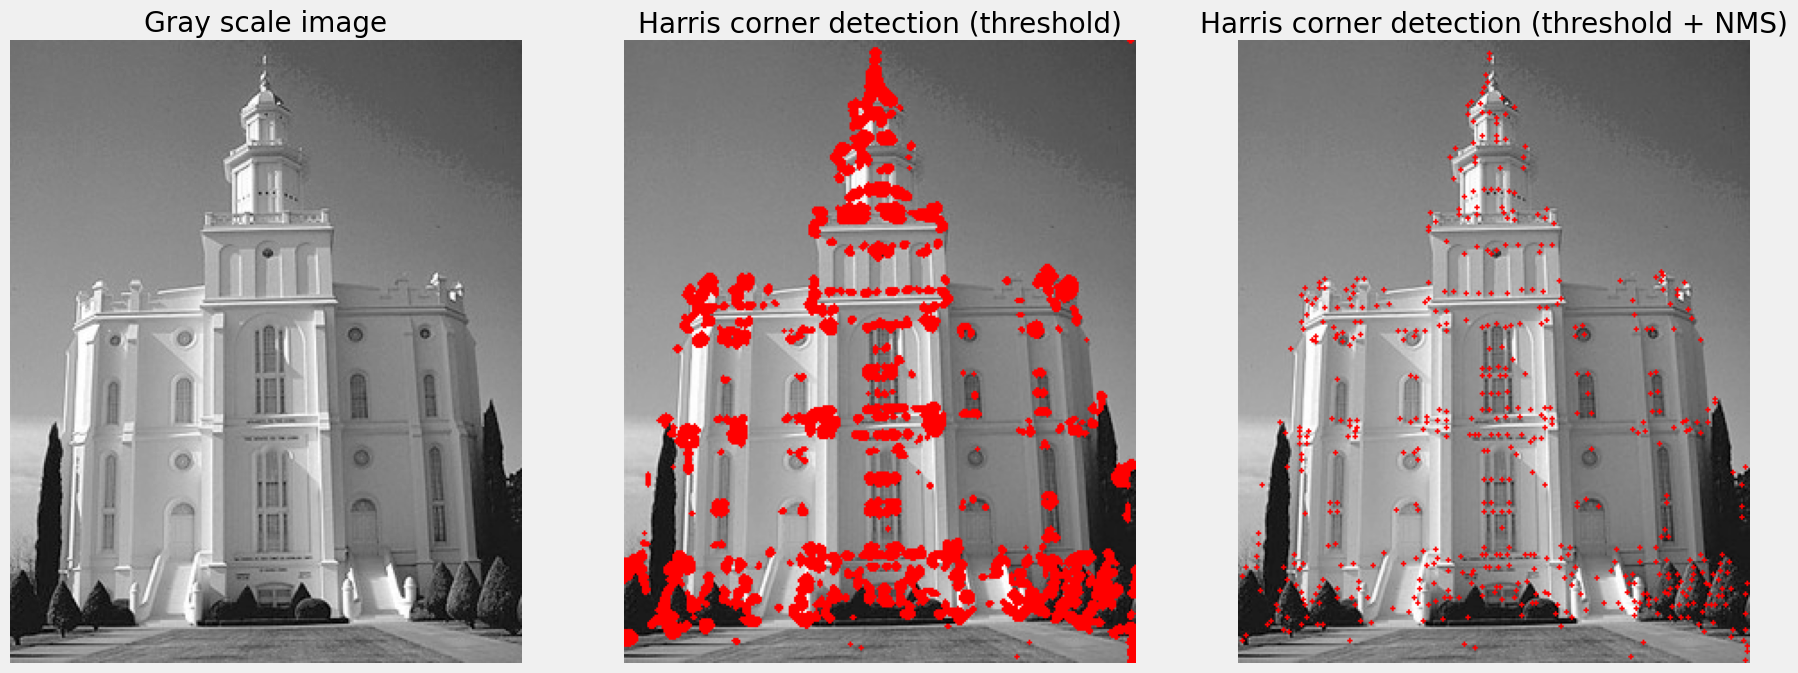

In [30]:
img = cv2.imread('../images/building.png')
k = 0.05
threshold = 2000.
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
H, W = gray_img.shape
# Write your code here:

response = harris_response(gray_img, k)
corners = [(c, r) for r,c in np.argwhere(response > threshold)]
harris_img_corner = draw_corners(img, corners)
# corners after NMS
corners_nms = nms(response, threshold=threshold)
harris_img_corner_nms = draw_corners(img, corners_nms)

# Show Original and detected corners on image
fig, axis = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
axis[0].imshow(gray_img, 'gray')
axis[0].grid(False)
axis[0].set_title('Gray scale image')
axis[0].set_axis_off()

axis[1].imshow(harris_img_corner, 'gray')
axis[1].grid(False)
axis[1].set_title('Harris corner detection (threshold)')
axis[1].set_axis_off()

axis[2].imshow(harris_img_corner_nms, 'gray')
axis[2].grid(False)
axis[2].set_title('Harris corner detection (threshold + NMS)')
axis[2].set_axis_off()

plt.show()